In [1]:
# Data handling
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Financial data
import yfinance as yf
from pandas_datareader import data as pdr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy.stats as stats
from scipy.stats import norm, t, laplace, cauchy, logistic, gennorm, ttest_ind
from scipy.optimize import minimize

# Machine Learning / Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
# -------------------- Step 0: Get S&P 500 tickers --------------------
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Add a User-Agent to mimic a browser
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)

# Parse HTML tables directly

html_io = StringIO(response.text)
sp500_table = pd.read_html(html_io)[0]
sp500_tickers = sp500_table['Symbol'].tolist()

# Fix tickers with '.' replaced by '-'
sp500_tickers = [t.replace('.', '-') for t in sp500_tickers]

# -------------------- Step 1: Download daily price data --------------------
data = yf.download(sp500_tickers, start="2015-01-01", end="2025-01-01", group_by='ticker', auto_adjust=False)
data.index = pd.to_datetime(data.index)
data = data.ffill()

# Filter tickers with >5% missing Adj Close values
total_rows = data.shape[0]
tickers_to_drop = [ticker for ticker in data.columns.levels[0] if data[ticker]['Adj Close'].isna().sum() > 0.05 * total_rows]
data_cleaned = data.drop(columns=tickers_to_drop, level=0)
data_cleaned.columns = data_cleaned.columns.remove_unused_levels()  # drop unused tickers
data = data_cleaned
remaining_tickers = data.columns.levels[0]

print(f"Number of tickers remaining: {len(remaining_tickers)}")

# -------------------- Step 2: Download SPY (market proxy) --------------------
spy = yf.download('SPY', start="2015-01-01", end="2025-01-01", auto_adjust=False)
spy.index = pd.to_datetime(spy.index)
spy = spy.dropna()
spy_adj_close = spy['Adj Close']


# Daily differences and log returns
daily_diff = spy_adj_close.diff().dropna()
log_returns = np.log(spy_adj_close / spy_adj_close.shift(1)).dropna()

# -------------------- Step 3: Extract Adjusted Close for all tickers --------------------
adj_close = data.xs('Adj Close', level=1, axis=1).copy()
adj_close.index = pd.to_datetime(adj_close.index)
adj_close = adj_close.sort_index().dropna(how='all')

# Compute daily returns per ticker
daily_returns = adj_close.pct_change().iloc[1:]  # remove first NaN row

# -------------------- Step 4: Download macroeconomic variables --------------------
macro_vars = [
    'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'UMCSENT', 'RSAFS', 'INDPRO', 'M2SL'
]

# Resample SPY monthly to month-end
spy_monthly = spy_adj_close.resample('ME').last()
spy_monthly.rename(columns={'SPY': 'AdjClose'}, inplace=True)

# Download macro data from FRED
fred_api_key = '01e70deb498854ccfe62acfb9630301b'
macro_df = pdr.DataReader(macro_vars, 'fred', start='2015-01-01', end='2025-01-01', api_key=fred_api_key)
macro_df = macro_df.resample('ME').last()

# Merge SPY with macro data
df = spy_monthly.join(macro_df, how='inner').dropna()

# -------------------- Step 5: Monthly return binary target --------------------
monthly_diff = df['AdjClose'].diff()
monthly_diff = (monthly_diff > 0).astype(int)

# -------------------- Step 6: Top/Bottom 50 daily performers --------------------
X_stocks = 50

top_X_gainers = daily_returns.apply(lambda row: row.nlargest(X_stocks).index.tolist(), axis=1)
top_X_losers  = daily_returns.apply(lambda row: row.nsmallest(X_stocks).index.tolist(), axis=1)

[*********************100%***********************]  503 of 503 completed


Number of tickers remaining: 468


[*********************100%***********************]  1 of 1 completed


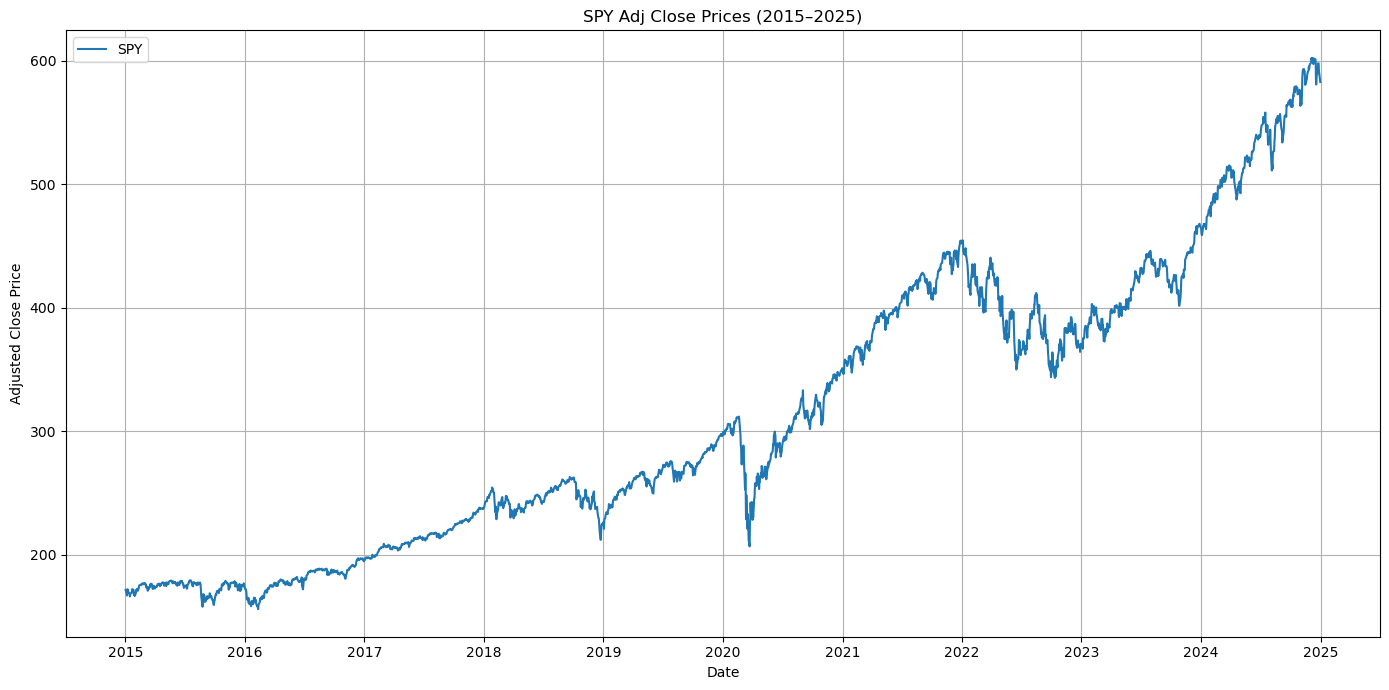

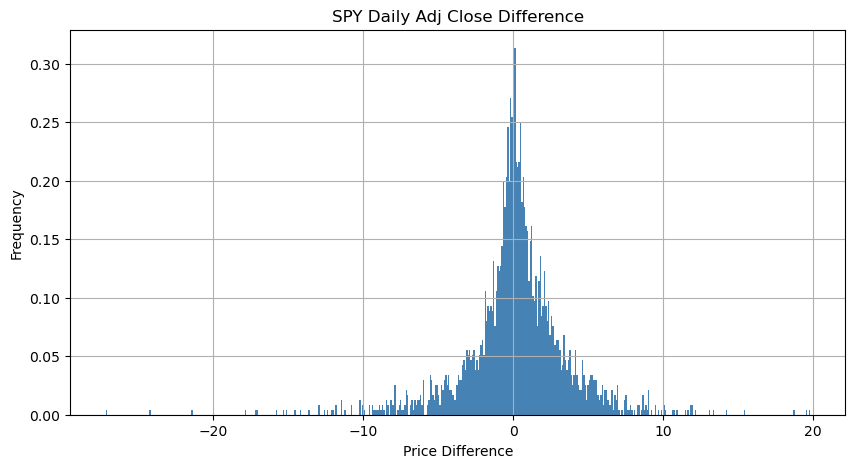

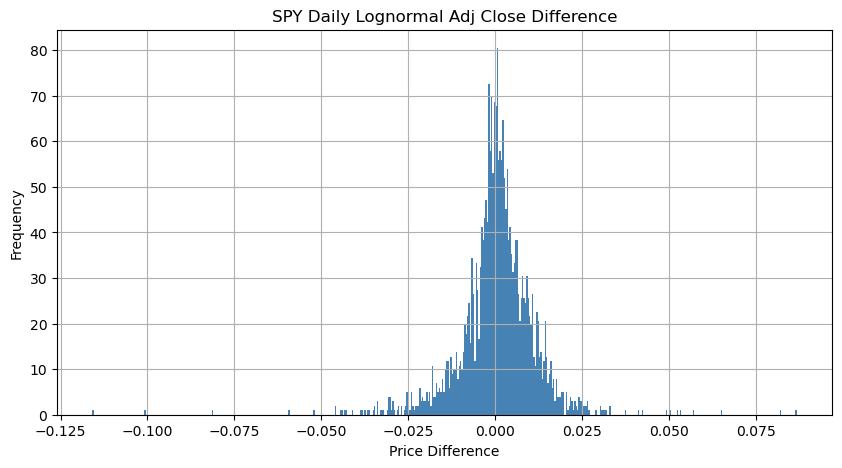

In [4]:
# Plot Graph

plt.figure(figsize=(14, 7))
plt.plot(spy_adj_close.index, spy_adj_close, label='SPY')
plt.title('SPY Adj Close Prices (2015–2025)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot histogram

plt.figure(figsize=(10, 5))
plt.hist(daily_diff, bins=500, color='steelblue', density=True)
plt.title('SPY Daily Adj Close Difference')
plt.xlabel('Price Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=500, color='steelblue', density=True)
plt.title('SPY Daily Lognormal Adj Close Difference')
plt.xlabel('Price Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

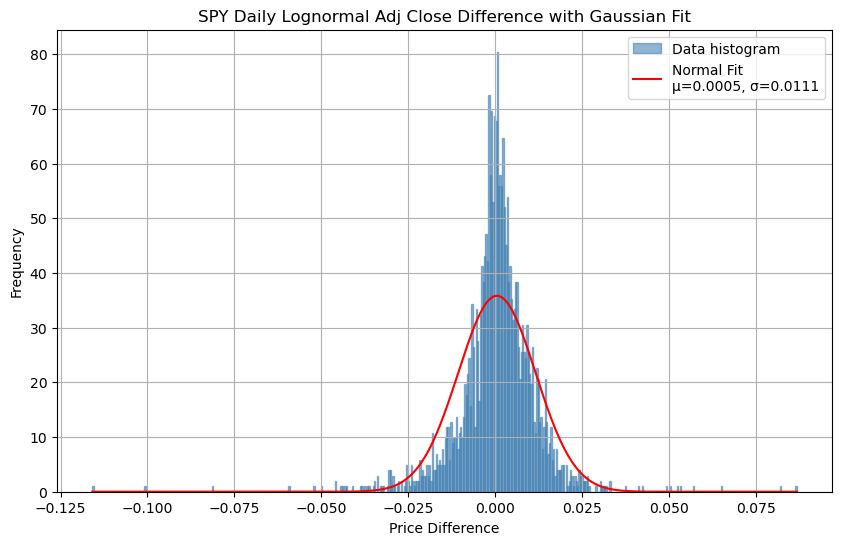

In [7]:
# Fit Gaussian (Normal) distribution
mu, sigma = norm.fit(log_returns)

# Create x values for the PDFs
x = np.linspace(log_returns.min(), log_returns.max(), 500)

# Compute PDFs
pdf_normal = norm.pdf(x, mu, sigma)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(log_returns, bins=500, density=True, alpha=0.6, color='steelblue', edgecolor='steelblue', label='Data histogram')

# Plot Gaussian fit
plt.plot(x, pdf_normal, color = 'red', linewidth=1.5, label=f'Normal Fit\nμ={mu:.4f}, σ={sigma:.4f}')

plt.title('SPY Daily Lognormal Adj Close Difference with Gaussian Fit')
plt.xlabel('Price Difference')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

Normal Distribution:
Parameters: (0.0004860918680805867, 0.011134724469982853)
p-value: [2.91095601e-25]

Student's t Distribution:
Parameters: (2.6917323667372175, 0.0008912510549694819, 0.006411396640621838)
p-value: [0.07375279]

Laplace Distribution:
Parameters: (0.0005962244603771613, 0.007272921613135504)
p-value: [0.02992089]

Cauchy Distribution:
Parameters: (0.000766285857474457, 0.004508257105320632)
p-value: [8.48336719e-06]

Logistic Distribution:
Parameters: (0.0007878832657096292, 0.0053649346563783415)
p-value: [8.47064239e-07]

Generalized Normal Distribution:
Parameters: (0.8607022365727599, 0.0005439997232939684, 0.005707232638895993)
p-value: [0.14712362]


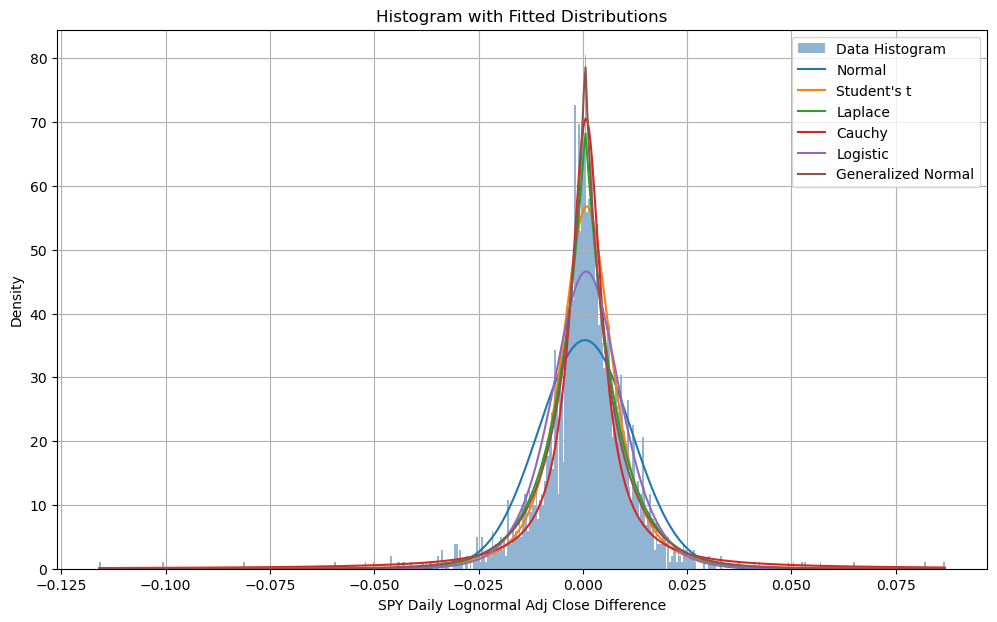

In [9]:
try:
    params_norm = stats.norm.fit(log_returns)
    ks_stat_norm, p_value_norm = stats.kstest(log_returns, 'norm', args=params_norm)
    print("Normal Distribution:")
    print("Parameters:", params_norm)
    print("p-value:", p_value_norm)
except Exception as e:
    print("Normal Distribution fit failed:", e)

try:
    params_t = stats.t.fit(log_returns)
    ks_stat_t, p_value_t = stats.kstest(log_returns, 't', args=params_t)
    print("\nStudent's t Distribution:")
    print("Parameters:", params_t)
    print("p-value:", p_value_t)
except Exception as e:
    print("Student's t Distribution fit failed:", e)

try:
    params_laplace = stats.laplace.fit(log_returns)
    ks_stat_laplace, p_value_laplace = stats.kstest(log_returns, 'laplace', args=params_laplace)
    print("\nLaplace Distribution:")
    print("Parameters:", params_laplace)
    print("p-value:", p_value_laplace)
except Exception as e:
    print("Laplace Distribution fit failed:", e)

try:
    params_cauchy = stats.cauchy.fit(log_returns)
    ks_stat_cauchy, p_value_cauchy = stats.kstest(log_returns, 'cauchy', args=params_cauchy)
    print("\nCauchy Distribution:")
    print("Parameters:", params_cauchy)
    print("p-value:", p_value_cauchy)
except Exception as e:
    print("Cauchy Distribution fit failed:", e)

try:
    params_logistic = stats.logistic.fit(log_returns)
    ks_stat_logistic, p_value_logistic = stats.kstest(log_returns, 'logistic', args=params_logistic)
    print("\nLogistic Distribution:")
    print("Parameters:", params_logistic)
    print("p-value:", p_value_logistic)
except Exception as e:
    print("Logistic Distribution fit failed:", e)

try:
    params_gennorm = stats.gennorm.fit(log_returns)
    ks_stat_gennorm, p_value_gennorm = stats.kstest(log_returns, 'gennorm', args=params_gennorm)
    print("\nGeneralized Normal Distribution:")
    print("Parameters:", params_gennorm)
    print("p-value:", p_value_gennorm)
except Exception as e:
    print("Generalized Normal Distribution fit failed:", e)


plt.figure(figsize=(12, 7))
count, bins, ignored = plt.hist(log_returns, bins=500, density=True, alpha=0.6, color='steelblue', label='Data Histogram')

# Create points for PDF plot
x = np.linspace(bins[0], bins[-1], 500)

# Plot Normal
pdf_norm = norm.pdf(x, *params_norm)
plt.plot(x, pdf_norm, label='Normal', lw=1.5)

# Plot Student's t
pdf_t = t.pdf(x, *params_t)
plt.plot(x, pdf_t, label="Student's t", lw=1.5)

# Plot Laplace
pdf_laplace = laplace.pdf(x, *params_laplace)
plt.plot(x, pdf_laplace, label='Laplace', lw=1.5)

# Plot Cauchy
pdf_cauchy = cauchy.pdf(x, *params_cauchy)
plt.plot(x, pdf_cauchy, label='Cauchy', lw=1.5)

# Plot Logistic
pdf_logistic = logistic.pdf(x, *params_logistic)
plt.plot(x, pdf_logistic, label='Logistic', lw=1.5)

# Plot Generalized Normal
pdf_gennorm = gennorm.pdf(x, *params_gennorm)
plt.plot(x, pdf_gennorm, label='Generalized Normal', lw=1.5)

plt.title('Histogram with Fitted Distributions')
plt.xlabel('SPY Daily Lognormal Adj Close Difference')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# -------------------------
# 1) For specific stock, check dates in outlier quantile
# -------------------------

stock = 'JPM'
# Extract adjusted close prices from the downloaded data
stock_adj_close = data[stock]['Adj Close']

# Calculate log returns
stock_log_returns = np.log(stock_adj_close / stock_adj_close.shift(1)).dropna()

x_quantile = 0.05
lower_cutoff = stock_log_returns.quantile(x_quantile)
upper_cutoff = stock_log_returns.quantile(1 - x_quantile)

# Filter tail data
tail_data = stock_log_returns[(stock_log_returns <= lower_cutoff) | (stock_log_returns >= upper_cutoff)]

tail_data = tail_data.to_frame(name='log_return')
tail_data['YearMonth'] = tail_data.index.to_period('M')

# Count most common Year-Month
year_month_counts = tail_data['YearMonth'].value_counts().sort_values(ascending=False)

print(f"1) Most common Year-Months tail events for stock {stock} (q={x_quantile}):")
print(year_month_counts.head(5))


# -------------------------
# 2) Top 5 gainers/losers in a period of time
# -------------------------
start = '2023-07-01'
end   = '2023-12-31'

period_prices = adj_close.loc[start:end].dropna(how='any', axis=1)
cum_return = period_prices.iloc[-1] / period_prices.iloc[0] - 1
top5_gainers_period = cum_return.sort_values(ascending=False).head(5)
top5_losers_period  = cum_return.sort_values(ascending=True).head(5)

print(f"\n2) Top 5 gainers in period {start} - {end}:")
print(top5_gainers_period.to_string())
print(f"\n2) Top 5 losers in period  {start} - {end}:")
print(top5_losers_period.to_string())


# -------------------------
# 3) Top 5 single-month gainers/losers
# -------------------------
monthly_prices = adj_close.resample('ME').last().dropna(how='all', axis=1)
monthly_ret = monthly_prices.pct_change().dropna(how='all')

best_month_val  = monthly_ret.max()
best_month_idx  = monthly_ret.idxmax()
worst_month_val = monthly_ret.min()
worst_month_idx = monthly_ret.idxmin()

best_month_df = pd.DataFrame({
    'ticker': best_month_val.index,
    'best_month_return': best_month_val.values,
    'month': best_month_idx.values
}).set_index('ticker')

worst_month_df = pd.DataFrame({
    'ticker': worst_month_val.index,
    'worst_month_return': worst_month_val.values,
    'month': worst_month_idx.values
}).set_index('ticker')

# Convert to year-month strings
best_month_df['month'] = best_month_df['month'].dt.strftime('%Y-%m')
worst_month_df['month'] = worst_month_df['month'].dt.strftime('%Y-%m')

top5_single_month_gainers = best_month_df['best_month_return'].sort_values(ascending=False).head(5)
top5_single_month_losers  = worst_month_df['worst_month_return'].sort_values(ascending=True).head(5)

print("\n3) Top 5 single-month gainers:")
print(best_month_df.loc[top5_single_month_gainers.index].to_string())
print("\n3) Top 5 single-month losers:")
print(worst_month_df.loc[top5_single_month_losers.index].to_string())


# -------------------------
# 4) Days with most simultaneous losses
# -------------------------
loss_counts = (daily_returns < 0).sum(axis=1).sort_values(ascending=False)
top_days_most_losses = loss_counts.head(5)

print("\n4) Top 5 dates with most simultaneous losing tickers:")
print(top_days_most_losses.to_string())


# -------------------------
# 5) Stocks with higher number in tail events (separately left and right tails)
# -------------------------
x_quantile = 0.05
lower_q = daily_returns.quantile(x_quantile)
upper_q = daily_returns.quantile(1 - x_quantile)

# Count tail events in left tail (big losses)
left_tail_counts = pd.Series({
    col: (daily_returns[col] <= lower_q[col]).sum()
    for col in daily_returns.columns
}).sort_values(ascending=False)

# Count tail events in right tail (big gains)
right_tail_counts = pd.Series({
    col: (daily_returns[col] >= upper_q[col]).sum()
    for col in daily_returns.columns
}).sort_values(ascending=False)

print(f"\n5) Top 5 stocks by number of left tail (big losses) events (q={x_quantile}):")
print(left_tail_counts.head(5).to_string())

print(f"\n5) Top 5 stocks by number of right tail (big gains) events (q={x_quantile}):")
print(right_tail_counts.head(5).to_string())

1) Most common Year-Months tail events for stock JPM (q=0.05):
YearMonth
2020-03    19
2020-04    15
2020-05    10
2020-06     9
2023-03     9
Freq: M, Name: count, dtype: int64

2) Top 5 gainers in period 2023-07-01 - 2023-12-31:
Ticker
ERIE    0.614847
WSM     0.608271
KEY     0.560162
INTC    0.504956
KKR     0.474047

2) Top 5 losers in period  2023-07-01 - 2023-12-31:
Ticker
ALB    -0.366621
PAYC   -0.351007
EL     -0.254385
HSY    -0.250758
UAL    -0.250636

3) Top 5 single-month gainers:
        best_month_return    month
ticker                            
APA              2.138438  2020-04
SMCI             1.124158  2023-05
ENPH             1.101796  2015-12
EQT              1.063649  2020-04
BLDR             0.913043  2015-04

3) Top 5 single-month losers:
        worst_month_return    month
ticker                             
APA              -0.832263  2020-03
TRGP             -0.786728  2020-03
CZR              -0.713033  2020-03
NCLH             -0.705851  2020-03
OKE     

In [13]:
# Use Merged SPY with macro: df 

# Compute correlation
corr_matrix = df.corr()

# Print correlation of Adj Close with macro variables
print("Correlation with macro variables:")
for var in macro_vars:
    print(f"{var}: {corr_matrix.loc['AdjClose', var]:.4f}")

Correlation with macro variables:
UNRATE: -0.1641
CPIAUCSL: 0.9426
FEDFUNDS: 0.6466
UMCSENT: -0.7432
RSAFS: 0.9493
INDPRO: 0.2560
M2SL: 0.9243


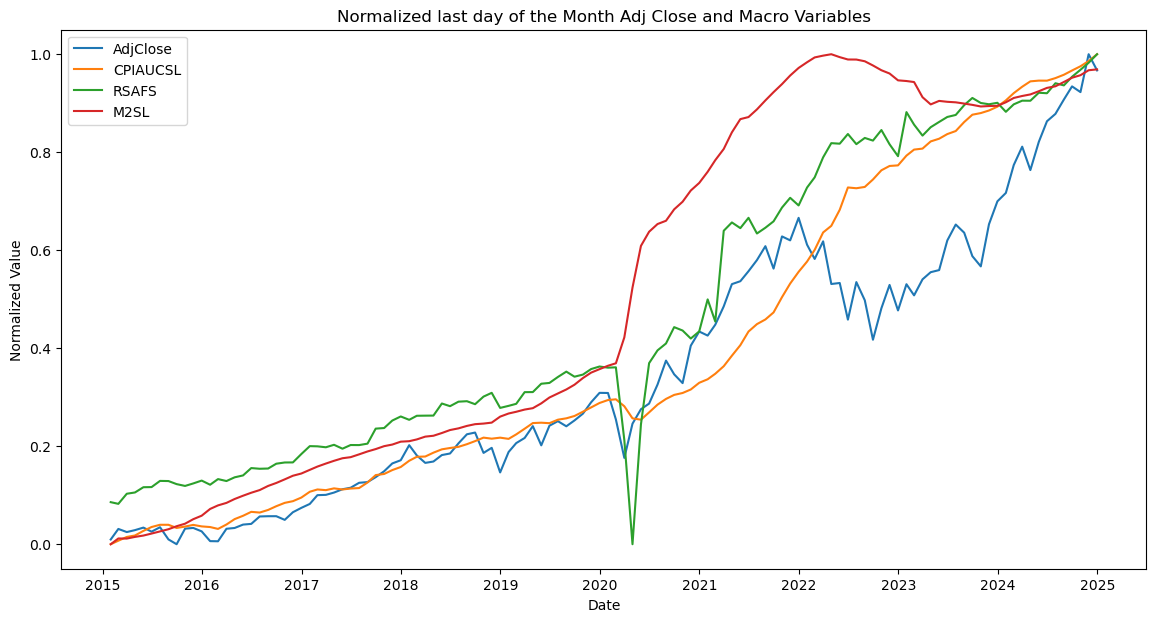

In [15]:
# Normalize data for plotting
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Plot normalized time series
plt.figure(figsize=(14,7))
for col in ['AdjClose', 'CPIAUCSL', 'RSAFS', 'M2SL']:
    plt.plot(df_norm.index, df_norm[col], label=col)
plt.title('Normalized last day of the Month Adj Close and Macro Variables')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend(loc='best')
plt.show()

Correlation matrix:
          AdjClose    UNRATE  CPIAUCSL  FEDFUNDS   UMCSENT     RSAFS  \
AdjClose  1.000000 -0.164061  0.942610  0.646584 -0.743157  0.949257   
UNRATE   -0.164061  1.000000 -0.271383 -0.445345 -0.015399 -0.302835   
CPIAUCSL  0.942610 -0.271383  1.000000  0.790364 -0.814021  0.978325   
FEDFUNDS  0.646584 -0.445345  0.790364  1.000000 -0.412395  0.700060   
UMCSENT  -0.743157 -0.015399 -0.814021 -0.412395  1.000000 -0.824014   
RSAFS     0.949257 -0.302835  0.978325  0.700060 -0.824014  1.000000   
INDPRO    0.256011 -0.908671  0.357625  0.529616 -0.059209  0.385237   
M2SL      0.924288 -0.060773  0.906674  0.491050 -0.879628  0.943022   

            INDPRO      M2SL  
AdjClose  0.256011  0.924288  
UNRATE   -0.908671 -0.060773  
CPIAUCSL  0.357625  0.906674  
FEDFUNDS  0.529616  0.491050  
UMCSENT  -0.059209 -0.879628  
RSAFS     0.385237  0.943022  
INDPRO    1.000000  0.134265  
M2SL      0.134265  1.000000  


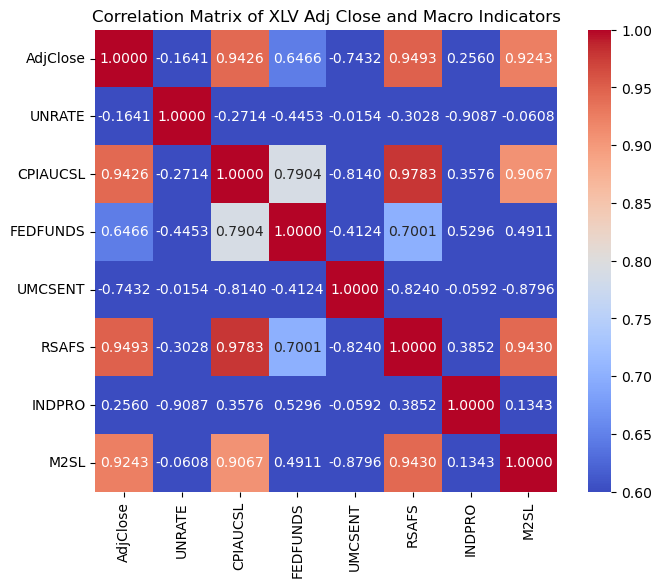

In [17]:
# Calculate correlation matrix on the original (non-scaled) data
#corr_matrix = df[['AdjClose', 'CPIAUCSL', 'RSAFS', 'M2SL']].corr()
corr_matrix = df[['AdjClose', 'UNRATE','CPIAUCSL','FEDFUNDS','UMCSENT','RSAFS','INDPRO','M2SL']].corr()
print("Correlation matrix:")
print(corr_matrix)



# Plot correlation matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap='coolwarm', vmin=0.6, vmax=1, square=True)
plt.title("Correlation Matrix of XLV Adj Close and Macro Indicators")
plt.show()

Linear Regression (no PCA, no Lasso)
-----------------------------------
Coefficients per variable:
  UNRATE: 10.3627
  CPIAUCSL: 5.7259
  FEDFUNDS: -23.8414
  UMCSENT: 3.8023
  RSAFS: 0.0004
  INDPRO: 1.3072
  M2SL: 0.0017
Intercept: -1907.066531137044
MAE: 17.5101
RMSE: 22.8038
R²: 0.9612


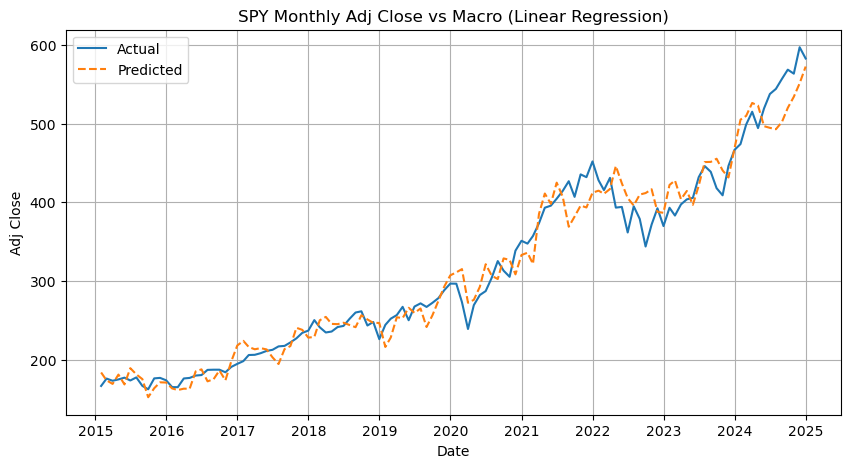

In [19]:
# Features (X) and target (y)
X = df[macro_vars].values
y = df['AdjClose'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate performance
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

# Print results
print("Linear Regression (no PCA, no Lasso)")
print("-----------------------------------")
print("Coefficients per variable:")
for var, coef in zip(macro_vars, model.coef_):
    print(f"  {var}: {coef:.4f}")
print("Intercept:", model.intercept_)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, y_pred, label='Predicted', linestyle='--')
plt.title("SPY Monthly Adj Close vs Macro (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.legend()
plt.grid(True)
plt.show()

Linear Regression with 5-Fold Cross-Validation
---------------------------------------------
MAE: 18.3819
RMSE: 24.0339
R²: 0.9569


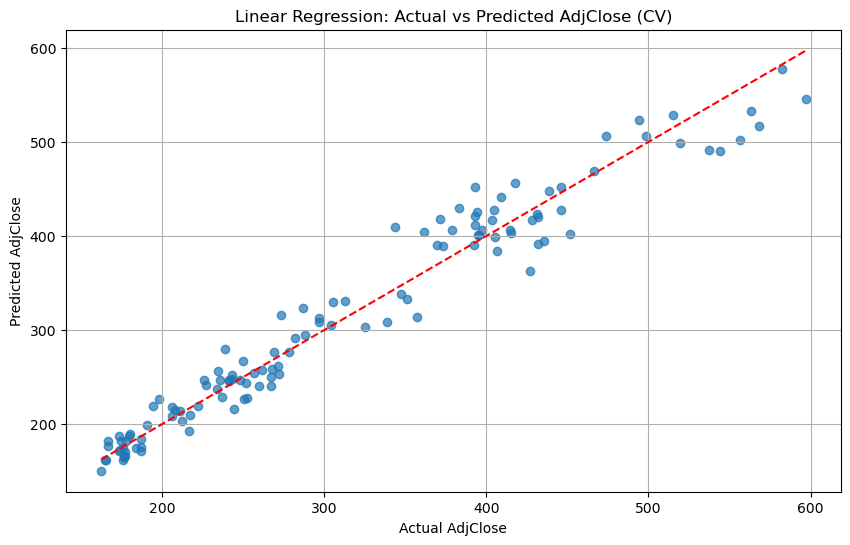

Coefficients per standardized variable:
  UNRATE: 17.8787
  CPIAUCSL: 150.5945
  FEDFUNDS: -44.4759
  UMCSENT: 54.1041
  RSAFS: 36.4391
  INDPRO: 3.9327
  M2SL: 6.1053
Coefficients: [ 17.87870152 150.59448897 -44.47589807  54.10411796  36.43909707
   3.9326856    6.10530641]
Intercept: 313.14657503763806


In [21]:
# Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Linear regression model
model = LinearRegression()

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=22)
y_pred_cv = cross_val_predict(model, X_scaled, y, cv=kf)

# Evaluate performance
mae = mean_absolute_error(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
r2 = r2_score(y, y_pred_cv)

print("Linear Regression with 5-Fold Cross-Validation")
print("---------------------------------------------")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Optional: plot predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y, y_pred_cv, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual AdjClose")
plt.ylabel("Predicted AdjClose")
plt.title("Linear Regression: Actual vs Predicted AdjClose (CV)")
plt.grid(True)
plt.show()



model.fit(X_scaled, y)

# Output coefficients per standardized variable
print("Coefficients per standardized variable:")
for var, coef in zip(['UNRATE','CPIAUCSL','FEDFUNDS','UMCSENT','RSAFS','INDPRO','M2SL'], model.coef_):
    print(f"  {var}: {coef:.4f}")


model.fit(X_scaled, y)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


KNN
 train_accuracy  test_accuracy  k
       0.711111       0.766667 10


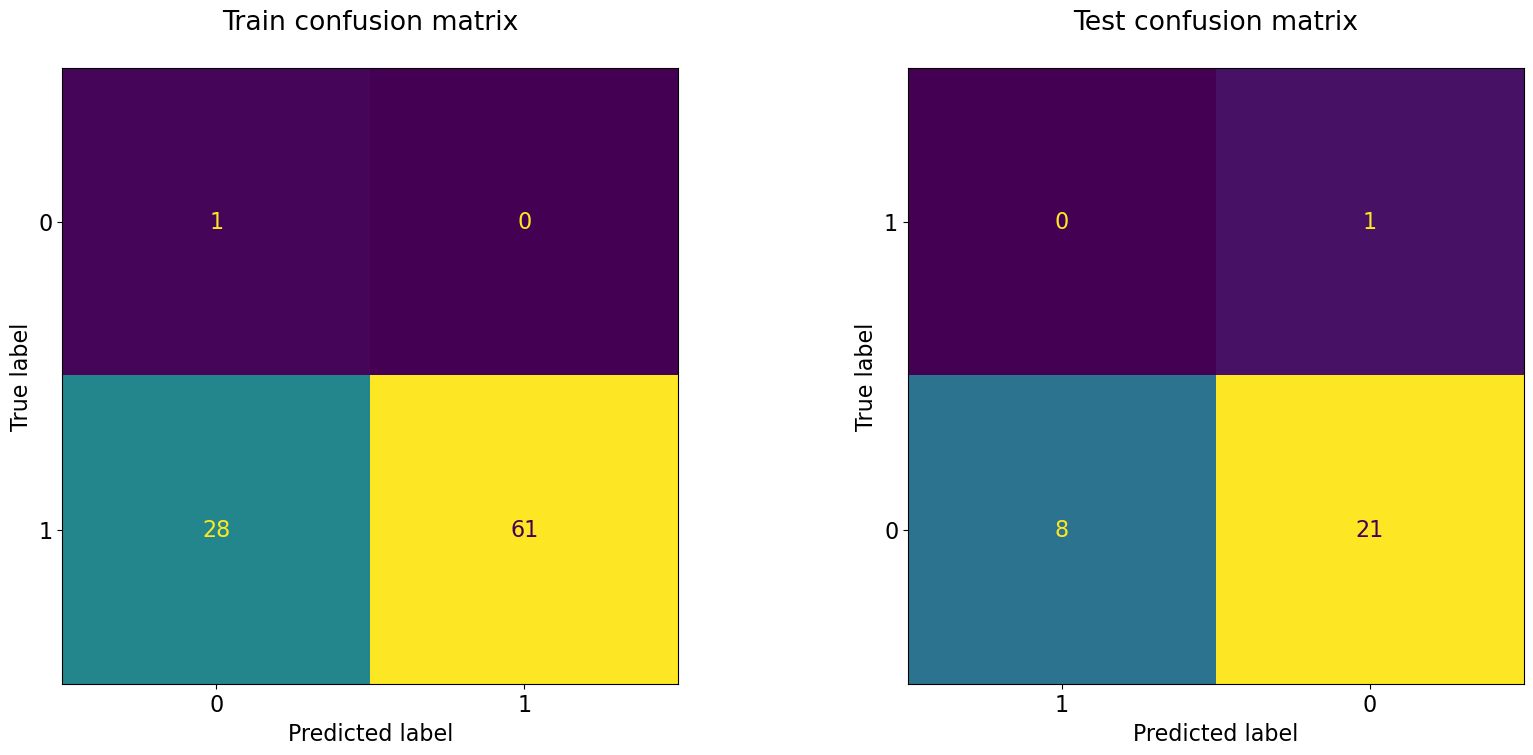

SVM
 train_accuracy  test_accuracy        C
       0.677778       0.733333 0.000001


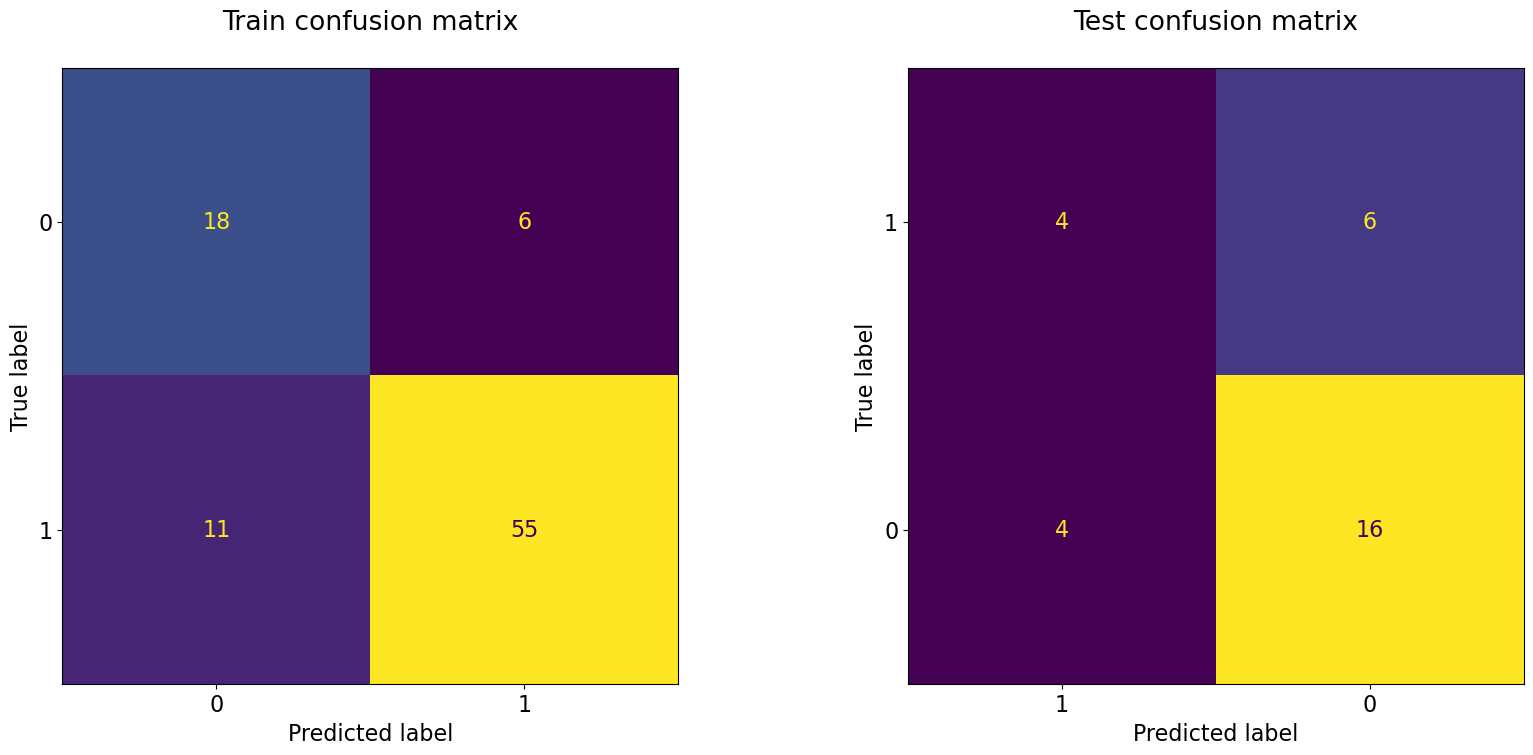

RandomForest
 train_accuracy  test_accuracy  k-fold  cv_accuracy   cv_std
       0.677778       0.733333       6     0.655556 0.059835


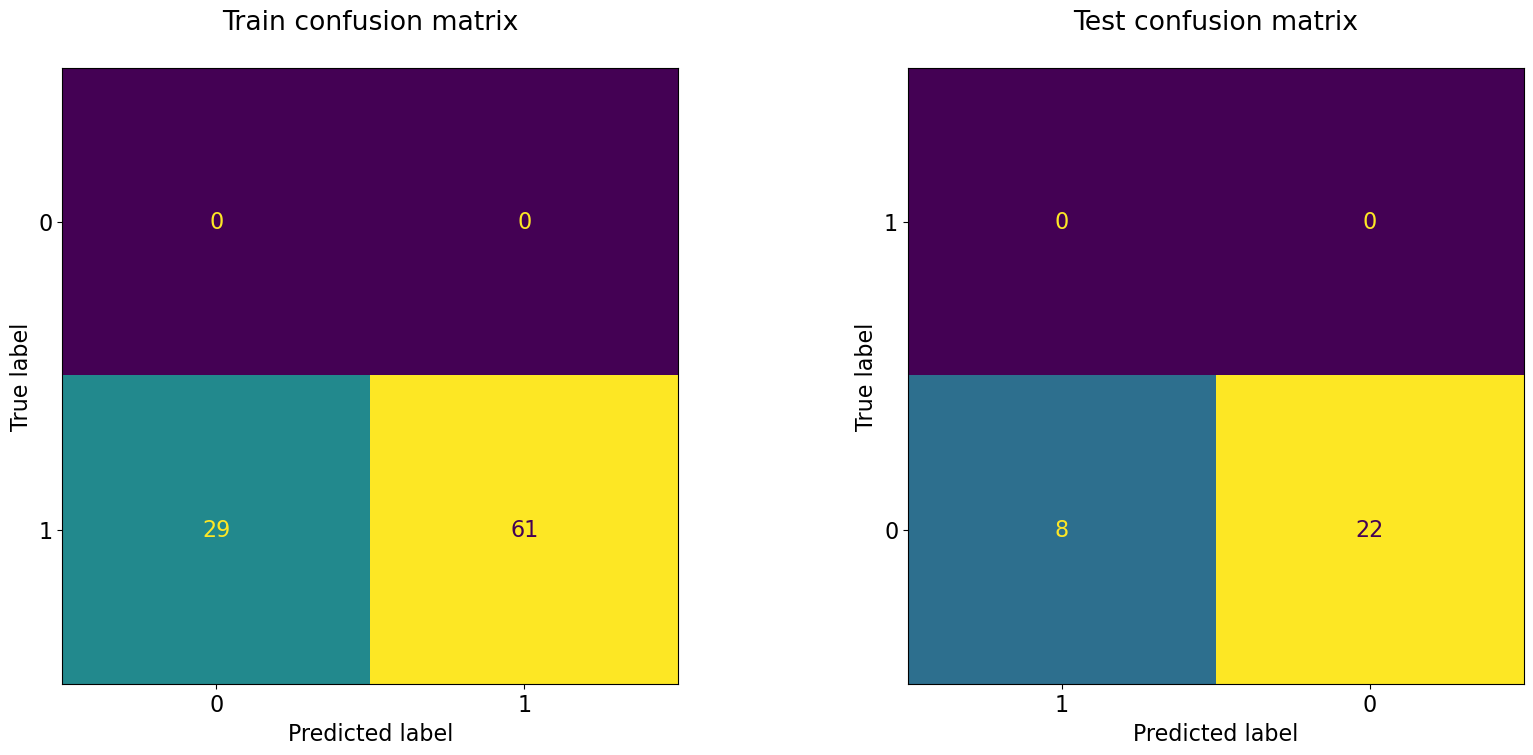

LogisticRegression
 train_accuracy  test_accuracy  k-fold  cv_accuracy   cv_std
       0.677778            0.7       4     0.677866 0.015872


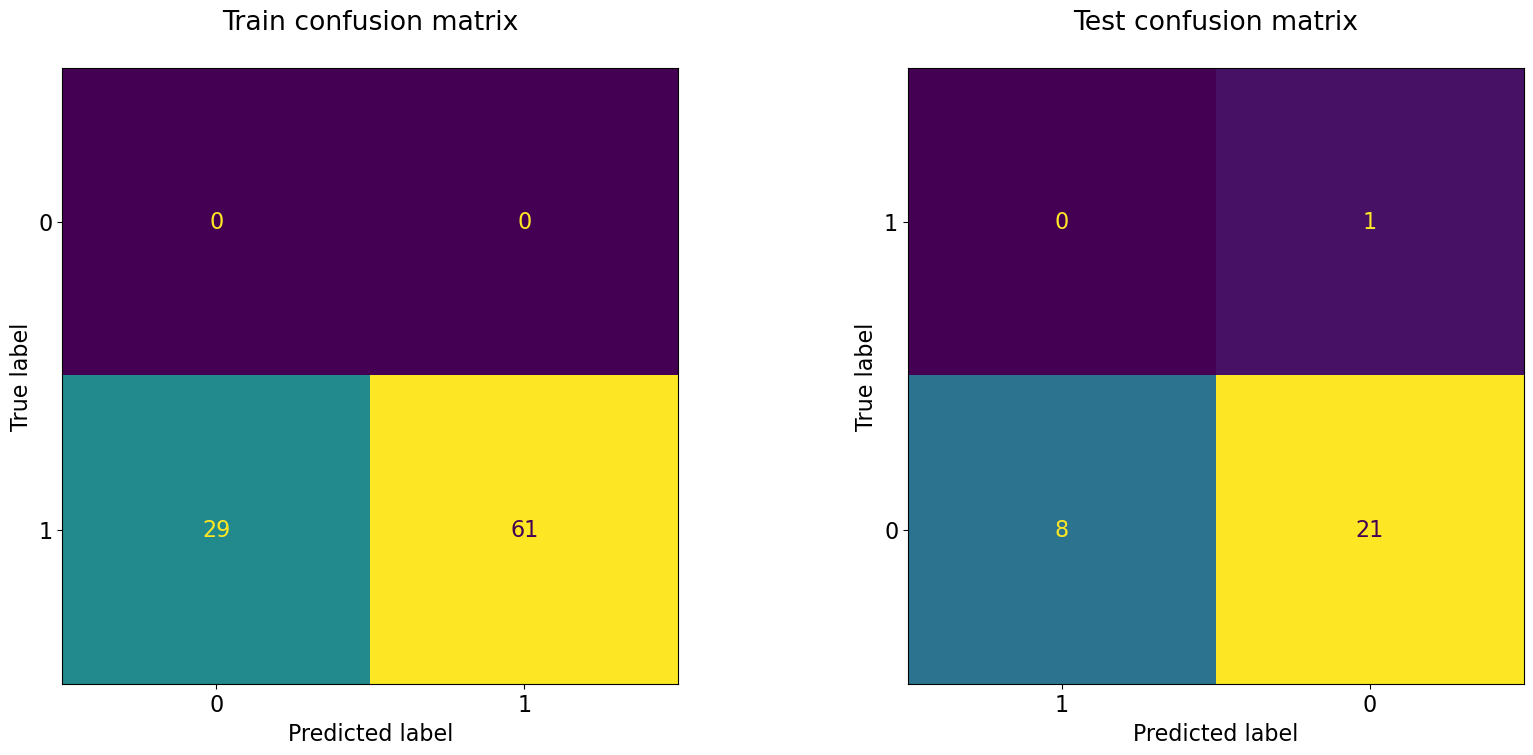

In [23]:
X = df[['CPIAUCSL', 'RSAFS', 'M2SL']]
#X = df[['UNRATE','CPIAUCSL','FEDFUNDS','UMCSENT','RSAFS','INDPRO','M2SL']]
y = monthly_diff 




#KNN
print("KNN")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

#Since monthly_diff already binary
transformer = StandardScaler()

# Find Best k
train_accs = []
test_accs = []
for k in range(1, 20):
    knn_pipe = Pipeline([('transformer', transformer),
                    ('knn', KNeighborsClassifier(n_neighbors=k))])
    knn_pipe.fit(X_train, y_train)
    train_accs.append(knn_pipe.score(X_train, y_train))
    test_accs.append(knn_pipe.score(X_test, y_test))

knn_results = pd.DataFrame({'train_accuracy': train_accs,
                           'test_accuracy': test_accs,
                           'k': range(1, 20)})

#to_string to remove first index
print(knn_results.nlargest(1, 'test_accuracy').to_string(index=False))

train_cmat = confusion_matrix(knn_pipe.predict(X_train), y_train)
test_cmat = confusion_matrix(knn_pipe.predict(X_test), y_test)
train_display = ConfusionMatrixDisplay(train_cmat, display_labels = y_train.unique().tolist())
test_display = ConfusionMatrixDisplay(test_cmat, display_labels = y_test.unique().tolist())

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
train_display.plot(ax = ax[0], colorbar = False)
ax[0].set_title('Train confusion matrix\n')
test_display.plot(ax = ax[1], colorbar = False)
ax[1].set_title('Test confusion matrix\n')
plt.show()


#------------------------------------------------------


# SVM 
print("SVM")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)
#encoder for categorical and scale numeric
transformer = StandardScaler()


Cs = [0.000001, 0.00001, 0.1, 1.0, 100, 10000]
train_accs = [] 
test_accs = []

for C in Cs:
    svc_pipe_C = Pipeline([('transformer', transformer),
        ('svc', SVC(kernel='rbf', C=C))])
    svc_pipe_C.fit(X_train, y_train)

    train_acc = svc_pipe_C.score(X_train, y_train)
    test_acc = svc_pipe_C.score(X_test, y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

svc_results = pd.DataFrame({
    'train_accuracy': train_accs,
    'test_accuracy': test_accs,
    'C': Cs})


print(svc_results.nlargest(1, 'test_accuracy').to_string(index=False))

train_cmat = confusion_matrix(svc_pipe_C.predict(X_train), y_train)
test_cmat = confusion_matrix(svc_pipe_C.predict(X_test), y_test)
train_display = ConfusionMatrixDisplay(train_cmat, display_labels = y_train.unique().tolist())
test_display = ConfusionMatrixDisplay(test_cmat, display_labels = y_test.unique().tolist())

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
train_display.plot(ax = ax[0], colorbar = False)
ax[0].set_title('Train confusion matrix\n')
test_display.plot(ax = ax[1], colorbar = False)
ax[1].set_title('Test confusion matrix\n');
plt.show()


#------------------------------------------------------

print("RandomForest")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

k_fold = 6
forest = RandomForestClassifier(max_depth = 1, random_state = 22)
forest.fit(X_train, y_train)
train_acc = forest.score(X_train, y_train)
test_acc = forest.score(X_test, y_test)

forest_scores = cross_val_score(forest, X_train, y_train, cv=k_fold)

random_forest_results = pd.DataFrame({
    'train_accuracy': [train_acc],
    'test_accuracy': [test_acc],
    'k-fold': [k_fold],
    'cv_accuracy': [forest_scores.mean()],
    'cv_std': [forest_scores.std()]})
print(random_forest_results.to_string(index=False))

train_cmat = confusion_matrix(forest.predict(X_train), y_train)
test_cmat = confusion_matrix(forest.predict(X_test), y_test)
train_display = ConfusionMatrixDisplay(train_cmat, display_labels = y_train.unique().tolist())
test_display = ConfusionMatrixDisplay(test_cmat, display_labels = y_test.unique().tolist())

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
train_display.plot(ax = ax[0], colorbar = False)
ax[0].set_title('Train confusion matrix\n')
test_display.plot(ax = ax[1], colorbar = False)
ax[1].set_title('Test confusion matrix\n');
plt.show()


#------------------------------------------------------


print("LogisticRegression")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

k_fold = 4
logreg = LogisticRegression(random_state=22)

logreg.fit(X_train, y_train)
train_acc = logreg.score(X_train, y_train)
test_acc = logreg.score(X_test, y_test)

logreg_scores = cross_val_score(logreg, X_train, y_train, cv=k_fold)

logistic_regression_results = pd.DataFrame({
    'train_accuracy': [train_acc],
    'test_accuracy': [test_acc],
    'k-fold': [k_fold],
    'cv_accuracy': [logreg_scores.mean()],
    'cv_std': [logreg_scores.std()]})
print(logistic_regression_results.to_string(index=False))


train_cmat = confusion_matrix(logreg.predict(X_train), y_train)
test_cmat = confusion_matrix(logreg.predict(X_test), y_test)
train_display = ConfusionMatrixDisplay(train_cmat, display_labels = y_train.unique().tolist())
test_display = ConfusionMatrixDisplay(test_cmat, display_labels = y_test.unique().tolist())

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
train_display.plot(ax = ax[0], colorbar = False)
ax[0].set_title('Train confusion matrix\n')
test_display.plot(ax = ax[1], colorbar = False)
ax[1].set_title('Test confusion matrix\n');
plt.show()


In [25]:
# ------------ Parameters ------------
X_STOCKS = 50
INITIAL_CAPITAL = 1_000_000
TRADING_DAYS = 252
RISK_FREE = 0.02               # annualized
W_MIN, W_MAX = 0.0, 0.40       # long-only, capped per name

# ------------ Helpers ------------
def annualized_return(weights, mean_daily):
    return float(np.dot(weights, mean_daily) * TRADING_DAYS)

def annualized_vol(weights, cov_daily):
    return float(np.sqrt(weights @ cov_daily @ weights) * np.sqrt(TRADING_DAYS))

def neg_sharpe(weights, mean_daily, cov_daily, rf=RISK_FREE):
    vol = annualized_vol(weights, cov_daily)
    if vol <= 1e-12:
        return 1e9
    ret = annualized_return(weights, mean_daily)
    return -(ret - rf) / vol

def optimize_weights(mean_daily, cov_daily, w_min=W_MIN, w_max=W_MAX, rf=RISK_FREE):
    n = len(mean_daily)
    bounds = [(w_min, w_max)] * n
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    w0 = np.full(n, 1.0 / n)
    res = minimize(
        neg_sharpe, w0, args=(mean_daily, cov_daily, rf),
        method='SLSQP', bounds=bounds, constraints=cons,
        options={'maxiter': 500, 'ftol': 1e-9}
    )
    w = res.x
    w = np.clip(w, w_min, w_max)
    w /= w.sum()
    return w

def safe_select_top_bottom(prev_day_row, k=50):
    s = prev_day_row.dropna()
    if s.empty:
        return [], []
    s_sorted = s.sort_values()
    bottom = list(s_sorted.index[:min(k, len(s_sorted))])
    top = list(s_sorted.index[-min(k, len(s_sorted)):])
    return top, bottom

def sanitize_today_vectors(today_row: pd.Series, tickers: list):
    if len(tickers) == 0:
        return np.array([]), np.array([], dtype=int)
    sub = today_row.reindex(tickers)
    mask = sub.notna().values
    return sub[mask].values.astype(float), np.where(mask)[0]

# ------------ Main backtest (daily selection, yearly stats) ------------
years = sorted(daily_returns.index.year.unique())

capital_top = INITIAL_CAPITAL
capital_bottom = INITIAL_CAPITAL

yearly_returns_top = {}
yearly_returns_bottom = {}

# new variable to store all daily portfolios (tickers + weights)
all_daily_portfolios = {}  # {year: {day: {'top': {...}, 'bottom': {...}}}}

for year in years:
    year_mask = daily_returns.index.year == year
    year_days = daily_returns.index[year_mask]

    comp_top = 1.0
    comp_bottom = 1.0

    all_daily_portfolios[year] = {}

    for di, day in enumerate(year_days):
        try:
            prev_day = daily_returns.index[daily_returns.index.get_loc(day) - 1]
        except Exception:
            continue

        prev_row = daily_returns.loc[prev_day]
        top50, bottom50 = safe_select_top_bottom(prev_row, X_STOCKS)
        today_row = daily_returns.loc[day]

        daily_record = {'top': {}, 'bottom': {}}

        # --- Top50 ---
        if year == years[0]:
            rvals_top, keep_idx_top = sanitize_today_vectors(today_row, top50)
            n_top = len(rvals_top)
            if n_top > 0:
                w_top = np.full(n_top, 1.0 / n_top)
                day_ret_top = float(np.dot(w_top, rvals_top))
                comp_top *= (1.0 + day_ret_top)
                daily_record['top'] = {'tickers': list(np.array(top50)[keep_idx_top]),
                                       'weights': w_top.tolist()}
        else:
            prev_year_mask = daily_returns.index.year == (year - 1)
            prev_year_data = daily_returns.loc[prev_year_mask, top50].dropna(axis=1, how='all')
            cols_top = list(prev_year_data.columns)
            if len(cols_top) == 0:
                rvals_top, keep_idx_top = sanitize_today_vectors(today_row, top50)
                n_top = len(rvals_top)
                if n_top > 0:
                    w_top = np.full(n_top, 1.0 / n_top)
                    day_ret_top = float(np.dot(w_top, rvals_top))
                    comp_top *= (1.0 + day_ret_top)
                    daily_record['top'] = {'tickers': list(np.array(top50)[keep_idx_top]),
                                           'weights': w_top.tolist()}
            else:
                mu_top = prev_year_data.mean().values.astype(float)
                cov_top = prev_year_data.cov().values.astype(float)
                w_opt_top = optimize_weights(mu_top, cov_top)
                opt_cols = np.array(cols_top)
                rvals_top, keep_idx_today = sanitize_today_vectors(today_row, list(opt_cols))
                if len(rvals_top) > 0:
                    w_use = w_opt_top[keep_idx_today]
                    if w_use.sum() <= 1e-12:
                        w_use = np.full(len(rvals_top), 1.0 / len(rvals_top))
                    else:
                        w_use = w_use / w_use.sum()
                    day_ret_top = float(np.dot(w_use, rvals_top))
                    comp_top *= (1.0 + day_ret_top)
                    daily_record['top'] = {'tickers': list(opt_cols[keep_idx_today]),
                                           'weights': w_use.tolist()}

        # --- Bottom50 ---
        if year == years[0]:
            rvals_bot, keep_idx_bot = sanitize_today_vectors(today_row, bottom50)
            n_bot = len(rvals_bot)
            if n_bot > 0:
                w_bot = np.full(n_bot, 1.0 / n_bot)
                day_ret_bot = float(np.dot(w_bot, rvals_bot))
                comp_bottom *= (1.0 + day_ret_bot)
                daily_record['bottom'] = {'tickers': list(np.array(bottom50)[keep_idx_bot]),
                                          'weights': w_bot.tolist()}
        else:
            prev_year_mask = daily_returns.index.year == (year - 1)
            prev_year_data = daily_returns.loc[prev_year_mask, bottom50].dropna(axis=1, how='all')
            cols_bot = list(prev_year_data.columns)
            if len(cols_bot) == 0:
                rvals_bot, keep_idx_bot = sanitize_today_vectors(today_row, bottom50)
                n_bot = len(rvals_bot)
                if n_bot > 0:
                    w_bot = np.full(n_bot, 1.0 / n_bot)
                    day_ret_bot = float(np.dot(w_bot, rvals_bot))
                    comp_bottom *= (1.0 + day_ret_bot)
                    daily_record['bottom'] = {'tickers': list(np.array(bottom50)[keep_idx_bot]),
                                               'weights': w_bot.tolist()}
            else:
                mu_bot = prev_year_data.mean().values.astype(float)
                cov_bot = prev_year_data.cov().values.astype(float)
                w_opt_bot = optimize_weights(mu_bot, cov_bot)
                opt_cols = np.array(cols_bot)
                rvals_bot, keep_idx_today = sanitize_today_vectors(today_row, list(opt_cols))
                if len(rvals_bot) > 0:
                    w_use = w_opt_bot[keep_idx_today]
                    if w_use.sum() <= 1e-12:
                        w_use = np.full(len(rvals_bot), 1.0 / len(rvals_bot))
                    else:
                        w_use = w_use / w_use.sum()
                    day_ret_bot = float(np.dot(w_use, rvals_bot))
                    comp_bottom *= (1.0 + day_ret_bot)
                    daily_record['bottom'] = {'tickers': list(opt_cols[keep_idx_today]),
                                               'weights': w_use.tolist()}

        # store this day’s portfolio
        all_daily_portfolios[year][day] = daily_record

    yearly_returns_top[year] = comp_top - 1.0
    yearly_returns_bottom[year] = comp_bottom - 1.0
    capital_top *= comp_top
    capital_bottom *= comp_bottom

    print(f"Year {year}:  Top50 (opt) yearly return = {100*yearly_returns_top[year]:.2f}%   |   "
          f"Bottom50 (opt) yearly return = {100*yearly_returns_bottom[year]:.2f}%")

print(f"Top 50 Strategy -> Final Capital: ${capital_top:,.2f}, Total Return: {(capital_top / INITIAL_CAPITAL - 1) * 100:.2f}%")
print(f"Bottom 50 Strategy -> Final Capital: ${capital_bottom:,.2f}, Total Return: {(capital_bottom / INITIAL_CAPITAL - 1) * 100:.2f}%")

# Now you can access all_daily_portfolios[year][day]['top']['tickers'], ['weights']
# Same for ['bottom']    

Year 2015:  Top50 (opt) yearly return = 2.40%   |   Bottom50 (opt) yearly return = 8.52%
Year 2016:  Top50 (opt) yearly return = 12.24%   |   Bottom50 (opt) yearly return = 27.40%
Year 2017:  Top50 (opt) yearly return = 7.86%   |   Bottom50 (opt) yearly return = 38.80%
Year 2018:  Top50 (opt) yearly return = -11.93%   |   Bottom50 (opt) yearly return = 6.07%
Year 2019:  Top50 (opt) yearly return = 50.27%   |   Bottom50 (opt) yearly return = 50.52%
Year 2020:  Top50 (opt) yearly return = -0.45%   |   Bottom50 (opt) yearly return = 45.02%
Year 2021:  Top50 (opt) yearly return = 40.76%   |   Bottom50 (opt) yearly return = 75.51%
Year 2022:  Top50 (opt) yearly return = -9.74%   |   Bottom50 (opt) yearly return = -5.75%
Year 2023:  Top50 (opt) yearly return = 47.17%   |   Bottom50 (opt) yearly return = 26.58%
Year 2024:  Top50 (opt) yearly return = 9.34%   |   Bottom50 (opt) yearly return = 70.49%
Top 50 Strategy -> Final Capital: $3,339,092.93, Total Return: 233.91%
Bottom 50 Strategy -> F

In [27]:
# -------------------- Parameters --------------------
trading_days = 252
risk_free_rate = 0.02  # annualized


NUM_PORTFOLIOS = 500000
X_stocks = 50
W_MIN, W_MAX = 0.0, 0.4
RISK_FREE = 0.02
TRADING_DAYS = 252
epsilon_step = 0.001
EPSILONS = np.arange(0.001, 1.0 + epsilon_step, epsilon_step)
PORTFOLIOS_PER_EPS = NUM_PORTFOLIOS // len(EPSILONS)
PRINT_EVERY = 50000  # print progress


# -------------------- Collect all daily returns --------------------
# Initialize lists
all_gainers_returns = []
all_losers_returns = []

# Loop through years to collect portfolio daily returns
years = sorted(daily_returns.index.year.unique())
for i, year in enumerate(years):

    year_data = daily_returns[daily_returns.index.year == year]
    
    if i == 0:
        # Use equal weights for all tickers in the first year
        tickers = daily_returns.columns
        weights_g = np.array([1/len(tickers)]*len(tickers))
        weights_l = np.array([1/len(tickers)]*len(tickers))
        tickers_g = tickers
        tickers_l = tickers

    else:
        
        prev_data = daily_returns[daily_returns.index.year == years[i-1]]
        mean_returns = prev_data.mean().values
        cov_matrix = prev_data.cov().values

        # Select top/worst X stocks
        top_idx = np.argsort(mean_returns)[-X_stocks:]
        worst_idx = np.argsort(mean_returns)[:X_stocks]

        weights_g = optimize_weights(mean_returns[top_idx], cov_matrix[np.ix_(top_idx, top_idx)])
        weights_l = optimize_weights(mean_returns[worst_idx], cov_matrix[np.ix_(worst_idx, worst_idx)])
        tickers_g = daily_returns.columns[top_idx]
        tickers_l = daily_returns.columns[worst_idx]

    
    # Portfolio returns
    port_returns_g = year_data[tickers_g].values @ weights_g if len(weights_g) > 0 else np.zeros(len(year_data))
    port_returns_l = year_data[tickers_l].values @ weights_l if len(weights_l) > 0 else np.zeros(len(year_data))

    all_gainers_returns.extend(port_returns_g)
    all_losers_returns.extend(port_returns_l)


# Convert to Pandas Series
gainers_returns = pd.Series(all_gainers_returns)
losers_returns = pd.Series(all_losers_returns)

# -------------------- Compute performance metrics --------------------
def compute_metrics(daily_returns_series, trading_days=252, risk_free_rate=0.02):
    daily_returns_series = pd.Series(daily_returns_series).dropna()
    mean_daily_return = daily_returns_series.mean()
    daily_std = daily_returns_series.std()

    annualized_return = (1 + mean_daily_return) ** trading_days - 1
    annualized_vol = daily_std * np.sqrt(trading_days)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol if annualized_vol != 0 else np.nan

    return annualized_return, annualized_vol, sharpe_ratio

gainers_metrics = compute_metrics(gainers_returns, trading_days, risk_free_rate)
losers_metrics = compute_metrics(losers_returns, trading_days, risk_free_rate)

# -------------------- Compute SPY metrics --------------------
# Assuming you have spy_adj_close already defined
spy_series = spy_adj_close.iloc[:,0] if isinstance(spy_adj_close, pd.DataFrame) else spy_adj_close
spy_returns = spy_series.pct_change().dropna()
spy_metrics = compute_metrics(spy_returns, trading_days, risk_free_rate)

# -------------------- Summary DataFrame --------------------
metrics_df = pd.DataFrame({
    'Top X Gainers Strategy': gainers_metrics,
    'Top X Losers Strategy': losers_metrics,
    'SPY': spy_metrics
}, index=['Annual Return', 'Annual Std Dev', 'Sharpe Ratio'])

print(metrics_df)

# -------------------- Best strategy based on Sharpe --------------------
best_strategy = metrics_df.loc['Sharpe Ratio'].idxmax()
print(f"\nStrategy with highest Sharpe Ratio: {best_strategy}")


                Top X Gainers Strategy  Top X Losers Strategy       SPY
Annual Return                 0.239327               0.327918  0.148059
Annual Std Dev                0.218143               0.271560  0.176192
Sharpe Ratio                  1.005428               1.133886  0.726816

Strategy with highest Sharpe Ratio: Top X Losers Strategy


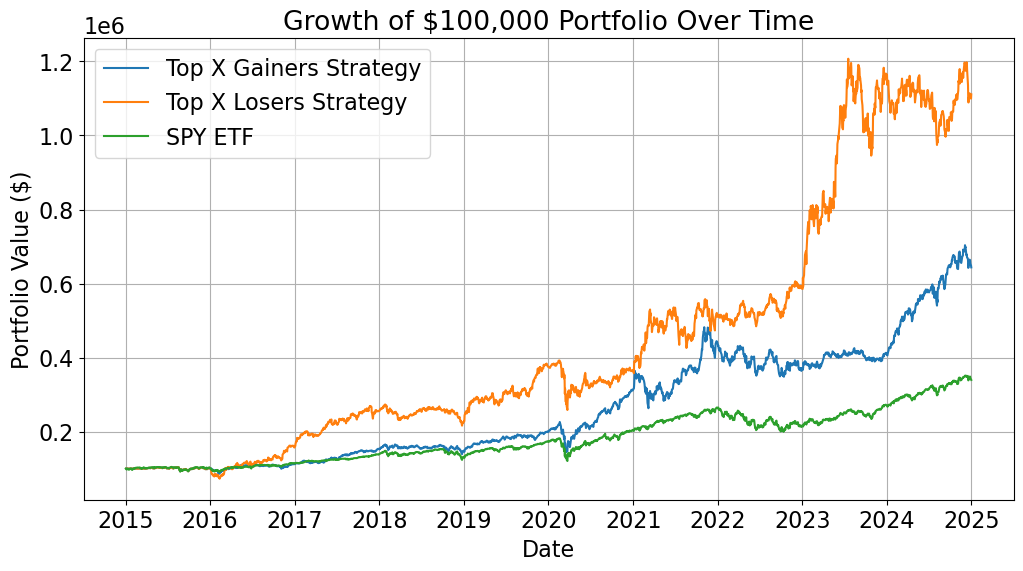

In [29]:
# -------------------- Build results DataFrames --------------------
results_gainers = pd.DataFrame(index=daily_returns.index)
results_losers = pd.DataFrame(index=daily_returns.index)
initial_capital = INITIAL_CAPITAL

# Capital over time starting from initial_capital
results_gainers['Capital'] = initial_capital * (1 + pd.Series(all_gainers_returns, index=daily_returns.index)).cumprod()
results_losers['Capital'] = initial_capital * (1 + pd.Series(all_losers_returns, index=daily_returns.index)).cumprod()

# Calculate daily returns from 'Capital'
results_gainers['Capital Return'] = results_gainers['Capital'].pct_change().fillna(0)
results_losers['Capital Return'] = results_losers['Capital'].pct_change().fillna(0)

# Calculate cumulative returns
results_gainers['Cumulative Return'] = (1 + results_gainers['Capital Return']).cumprod()
results_losers['Cumulative Return'] = (1 + results_losers['Capital Return']).cumprod()
spy_cum_returns = (1 + spy_adj_close.pct_change().fillna(0)).cumprod()

# Calculate portfolio values starting from 100,000 initial capital
results_gainers['Portfolio Value'] = results_gainers['Cumulative Return'] * 100000
results_losers['Portfolio Value'] = results_losers['Cumulative Return'] * 100000
spy_portfolio_value = spy_cum_returns * 100000

# -------------------- Plot all three portfolios --------------------
plt.figure(figsize=(12,6))
plt.plot(results_gainers.index, results_gainers['Portfolio Value'], label='Top X Gainers Strategy')
plt.plot(results_losers.index, results_losers['Portfolio Value'], label='Top X Losers Strategy')
plt.plot(spy_portfolio_value.index, spy_portfolio_value, label='SPY ETF')

plt.title('Growth of $100,000 Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

Simulated portfolios: 50000/500000 (epsilon=0.10)
Simulated portfolios: 100000/500000 (epsilon=0.20)
Simulated portfolios: 150000/500000 (epsilon=0.30)
Simulated portfolios: 200000/500000 (epsilon=0.40)
Simulated portfolios: 250000/500000 (epsilon=0.50)
Simulated portfolios: 300000/500000 (epsilon=0.60)
Simulated portfolios: 350000/500000 (epsilon=0.70)
Simulated portfolios: 400000/500000 (epsilon=0.80)
Simulated portfolios: 450000/500000 (epsilon=0.90)
Simulated portfolios: 500000/500000 (epsilon=1.00)


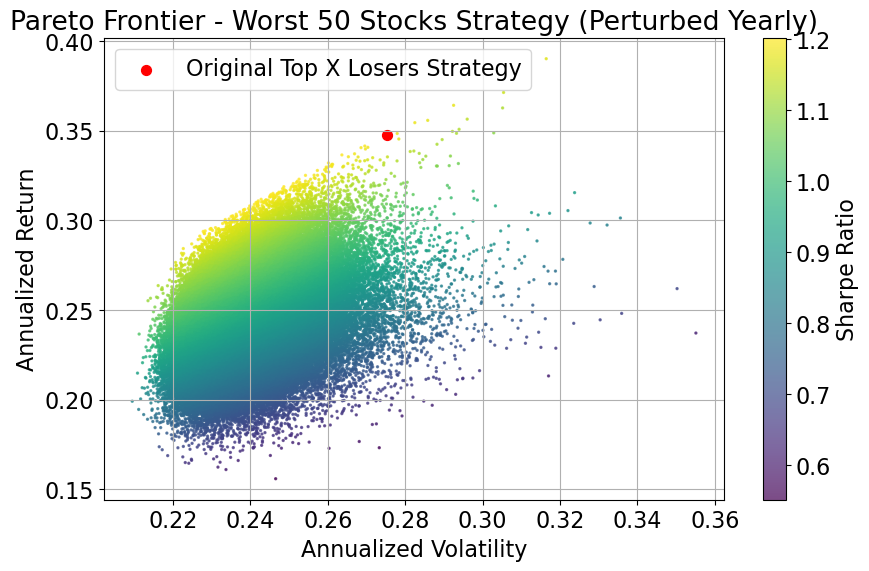

Original Top X Losers Strategy -> Annual Return: 0.3478, Volatility: 0.2754, Sharpe Ratio: 1.1902


In [31]:
# Pareto Frontier

# -------------------- Parameters --------------------
NUM_PORTFOLIOS = 500000
X_STOCKS = 50
W_MIN, W_MAX = 0.0, 0.4
RISK_FREE = 0.02
TRADING_DAYS = 252
epsilon_step = 0.001
EPSILONS = np.arange(0.001, 1.0 + epsilon_step, epsilon_step)
PORTFOLIOS_PER_EPS = NUM_PORTFOLIOS // len(EPSILONS)
PRINT_EVERY = 50000  # print progress

# -------------------- Function to compute annualized metrics --------------------
def compute_annualized_metrics(daily_series):
    daily_series = np.array(daily_series, dtype=float)
    mean_daily = np.nanmean(daily_series)
    std_daily = np.nanstd(daily_series)
    ann_ret = (1 + mean_daily) ** TRADING_DAYS - 1
    ann_vol = std_daily * np.sqrt(TRADING_DAYS)
    sharpe = (ann_ret - RISK_FREE) / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

# -------------------- Pre-extract daily returns & weights by year --------------------
yearly_data = {}

for year in sorted(all_daily_portfolios.keys()):
    days = sorted(all_daily_portfolios[year].keys())
    tickers = all_daily_portfolios[year][days[0]]['bottom']['tickers']
    base_weights = np.array(all_daily_portfolios[year][days[0]]['bottom']['weights'])

    # Pre-extract full year returns matrix (days × tickers)
    returns_matrix = daily_returns.loc[days, tickers].values.astype(float)
    returns_matrix = np.nan_to_num(returns_matrix)

    yearly_data[year] = {
        "returns_matrix": returns_matrix,
        "weights": base_weights
    }

# -------------------- Simulate perturbed portfolios (yearly) --------------------
annual_returns, annual_vols, sharpe_ratios = [], [], []
portfolio_counter = 0
years = sorted(yearly_data.keys())

for eps_idx, eps in enumerate(EPSILONS):
    for i in range(PORTFOLIOS_PER_EPS):
        portfolio_counter += 1
        if portfolio_counter % PRINT_EVERY == 0:
            print(f"Simulated portfolios: {portfolio_counter}/{NUM_PORTFOLIOS} (epsilon={eps:.2f})")

        perturbed_returns = []

        for year in years:
            base_weights = yearly_data[year]["weights"]
            returns_matrix = yearly_data[year]["returns_matrix"]

            # Perturb yearly weights except first year
            yearly_weights = base_weights.copy()
            if year != years[0]:
                yearly_weights = yearly_weights * (1 + np.random.uniform(-eps, eps, size=len(yearly_weights)))
                yearly_weights = np.clip(yearly_weights, W_MIN, W_MAX)
                yearly_weights /= yearly_weights.sum()

            # Vectorized daily returns: (days × tickers) @ (tickers,), otherwise tooo slow
            year_returns = returns_matrix @ yearly_weights
            perturbed_returns.extend(year_returns)

        ann_ret, ann_vol, sharpe = compute_annualized_metrics(perturbed_returns)
        annual_returns.append(ann_ret)
        annual_vols.append(ann_vol)
        sharpe_ratios.append(sharpe)


# Convert to numpy arrays
annual_returns = np.array(annual_returns)
annual_vols = np.array(annual_vols)
sharpe_ratios = np.array(sharpe_ratios)

# -------------------- Plot Pareto Frontier --------------------
plt.figure(figsize=(10,6))
plt.scatter(annual_vols, annual_returns, c=sharpe_ratios,
            cmap='viridis', alpha=0.7, s=2)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Pareto Frontier - Worst 50 Stocks Strategy (Perturbed Yearly)')

# Original Top X Losers Strategy point
orig_ann_ret = 0.347794
orig_ann_vol = 0.275412
orig_sharpe = 1.190196
plt.scatter(orig_ann_vol, orig_ann_ret, color='red', s=50,
            label='Original Top X Losers Strategy')

plt.legend()
plt.grid(True)
plt.show()

print(f"Original Top X Losers Strategy -> Annual Return: {orig_ann_ret:.4f}, "
      f"Volatility: {orig_ann_vol:.4f}, Sharpe Ratio: {orig_sharpe:.4f}")

In [33]:
# -------------------- Data --------------------
# daily portfolio returns for losers strategy
losers_daily_returns = results_losers['Capital Return'].dropna().values

# -------------------- Fit distributions --------------------

# Gaussian
mu_norm, sigma_norm = norm.fit(losers_daily_returns)
loglik_norm = np.sum(norm.logpdf(losers_daily_returns, loc=mu_norm, scale=sigma_norm))
k_norm = 2  # parameters: mu, sigma
aic_norm = 2*k_norm - 2*loglik_norm

# Student-t
df_t, mu_t, sigma_t = t.fit(losers_daily_returns)
loglik_t = np.sum(t.logpdf(losers_daily_returns, df_t, loc=mu_t, scale=sigma_t))
k_t = 3  # parameters: df, mu, sigma
aic_t = 2*k_t - 2*loglik_t

# Generalized Normal
beta_g, loc_g, scale_g = gennorm.fit(losers_daily_returns)
loglik_g = np.sum(gennorm.logpdf(losers_daily_returns, beta_g, loc=loc_g, scale=scale_g))
k_g = 3  # beta, loc, scale
aic_g = 2*k_g - 2*loglik_g

# -------------------- Compare --------------------
print("Fit results:")
print(f"Gaussian: mu={mu_norm:.6f}, sigma={sigma_norm:.6f}, AIC={aic_norm:.2f}")
print(f"Student-t: df={df_t:.2f}, mu={mu_t:.6f}, sigma={sigma_t:.6f}, AIC={aic_t:.2f}")
print(f"Generalized Normal: beta={beta_g:.6f}, loc={loc_g:.6f}, scale={scale_g:.6f}, AIC={aic_g:.2f}")

best_fit = min([('Gaussian', aic_norm), ('Student-t', aic_t), ('Generalized Normal', aic_g)], key=lambda x: x[1])
print(f"\nBest fitting distribution according to AIC: {best_fit[0]}")

Fit results:
Gaussian: mu=0.001101, sigma=0.016899, AIC=-13383.78
Student-t: df=3.28, mu=0.001018, sigma=0.011373, AIC=-13750.70
Generalized Normal: beta=0.998735, loc=0.000660, scale=0.011856, AIC=-13776.06

Best fitting distribution according to AIC: Generalized Normal


In [35]:
# Historic VAR
# 2 years window, 10 days horizon

import numpy as np
import pandas as pd

# -------------------- Parameters --------------------
portfolio_value = 100_000
var_horizon = 10             # 10-day VaR
calibration_days = 252 * 2   # 2-year rolling window
confidence_level = 0.95

# -------------------- Rolling VaR calculation --------------------
exceedances = 0
total_checks = 0
var_list = []
loss_list = []

# iterate over each day after initial calibration window, stopping var_horizon days before the end
for start_idx in range(len(losers_daily_returns) - calibration_days - var_horizon + 1):
    # calibration window for VaR
    calib_returns = losers_daily_returns[start_idx : start_idx + calibration_days]
    
    # compute 10-day cumulative returns in calibration window
    cum_returns = np.array([np.prod(1 + calib_returns[i:i+var_horizon]) - 1 
                            for i in range(len(calib_returns) - var_horizon + 1)])
    
    # historical VaR at confidence level
    hist_var = -np.percentile(cum_returns, (1 - confidence_level) * 100)
    
    # 10-day cumulative return for the next period to check exceedance
    test_returns = losers_daily_returns[start_idx + calibration_days : start_idx + calibration_days + var_horizon]
    test_cum = np.prod(1 + test_returns) - 1
    
    var_list.append(hist_var)
    loss_list.append(test_cum)
    
    total_checks += 1
    if -test_cum > hist_var:
        exceedances += 1

# -------------------- Results --------------------
print(f"Total 10-day VaR checks: {total_checks}")
print(f"Number of exceedances: {exceedances}")
print(f"Percentage of exceedances: {100 * exceedances / total_checks:.2f}%")

# Optional: convert to Pandas DataFrame for inspection
var_df = pd.DataFrame({
    'VaR_10d': var_list,
    'Loss_10d': loss_list,
    'Exceedance': [int(-loss > var) for loss, var in zip(loss_list, var_list)]
})
                    

Total 10-day VaR checks: 2002
Number of exceedances: 110
Percentage of exceedances: 5.49%


In [39]:
# Parametric VaR

# -------------------- Parameters --------------------
portfolio_value = 100_000        # starting capital
window_days = 252 * 2            # 2-year rolling window
horizon_days = 10                # 10-day VaR horizon
confidence_level = 0.95          # 95% VaR

# This assuming Gaussian
# z_alpha = norm.ppf(confidence_level) 

# This assuming Generalized Gaussian
beta = 0.998640
loc = 0.000660
scale = 0.011854

gnd_alpha = gennorm.ppf(confidence_level, beta, loc=loc, scale=scale)


# -------------------- Use existing daily returns --------------------
# daily portfolio returns for losers strategy (already computed)
returns = results_losers['Capital Return'].dropna().values
dates = results_losers['Capital Return'].dropna().index


# -------------------- Rolling parametric VaR --------------------
total_checks = 0
exceedances = 0
var_list = []
actual_list = []
check_dates = []


for i in range(window_days, len(returns) - horizon_days):
    # rolling window of past 2 years
    window = returns[i - window_days:i]
    mu = np.mean(window)
    sigma = np.std(window, ddof=1)

    # Gaussian 10-day parametric VaR (negative for losses)
    # var_10d = mu * horizon_days - sigma * np.sqrt(horizon_days) * z_alpha
    
    # Generalized Gaussian
    var_10d = - (gnd_alpha * np.sqrt(horizon_days))    

    # actual 10-day return
    actual_return = np.sum(returns[i:i + horizon_days])

    # check exceedance
    if actual_return < var_10d:
        exceedances += 1

    total_checks += 1
    var_list.append(var_10d)
    actual_list.append(actual_return)
    check_dates.append(dates[i + horizon_days - 1])  # last day of the 10-day horizon

# -------------------- Summary --------------------
percent_exceedances = 100 * exceedances / total_checks

print(f"Total {horizon_days}-day VaR checks: {total_checks}")
print(f"Number of exceedances: {exceedances}")
print(f"Percentage of exceedances: {percent_exceedances:.2f}%")

Total 10-day VaR checks: 2001
Number of exceedances: 39
Percentage of exceedances: 1.95%


Total 10-day VaR checks: 2002
Number of exceedances: 52
Percentage of exceedances: 2.60%


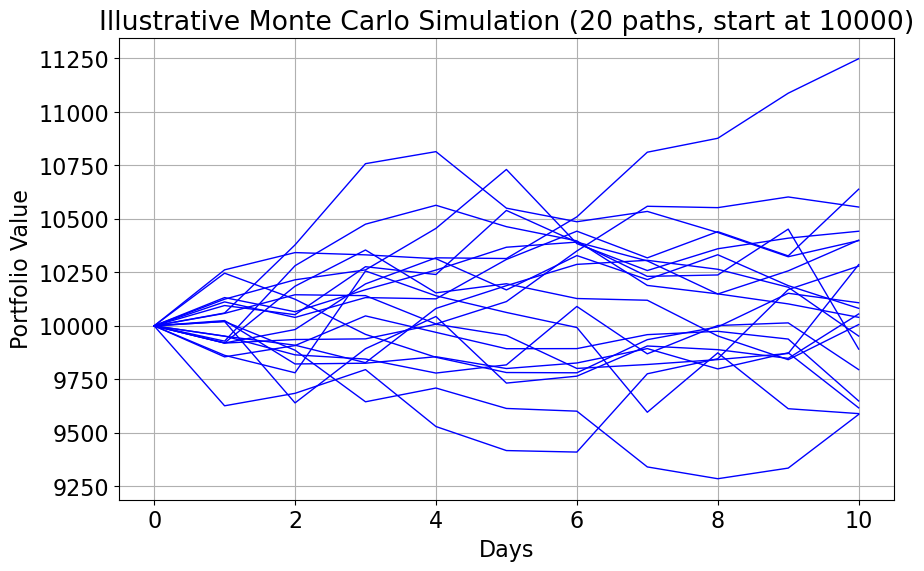

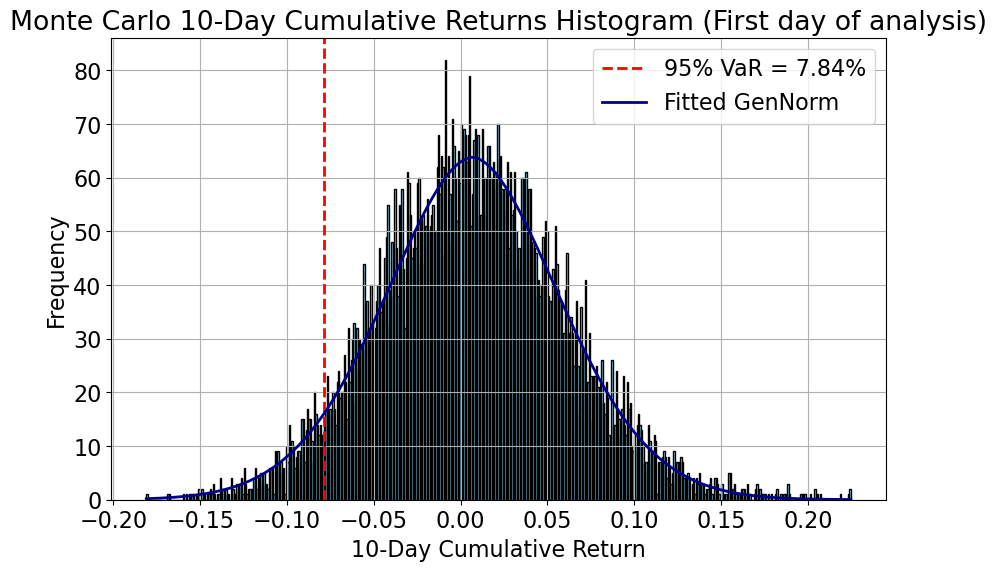

95% 10-Day Monte Carlo VaR (first day of analysis): 7.84%


In [41]:
# Monte Carlo

# -------------------- Parameters --------------------
portfolio_value = 10000       # starting capital for illustration
horizon_days = 10             # VaR horizon
rolling_window = 252*2        # 2 years of daily returns for calibration
confidence_interval = 0.95
num_simulations = 10000        # Monte Carlo paths
num_plot_paths = 20           # number of paths to show in the example plot

# This assuming Generalized Gaussian (you had these)
beta = 0.998640
loc = 0.000660
scale = 0.011854


# -------------------- Data --------------------
losers_daily_returns = results_losers['Capital Return'].dropna().values
num_days = len(losers_daily_returns)

# -------------------- Rolling Monte Carlo VaR --------------------
start_idx = rolling_window
end_idx = num_days - horizon_days + 1

var_rolling = []
exceedances = 0
total_checks = 0


for i in range(start_idx, end_idx):
    window_returns = losers_daily_returns[i-rolling_window:i]
    mu = np.mean(window_returns)
    sigma = np.std(window_returns)

    # Gaussian
    # simulated_paths = np.random.normal(loc=mu, scale=sigma, size=(num_simulations, horizon_days))

    # Generalized Gaussian
    simulated_paths = gennorm.rvs(beta, loc=loc, scale=scale, size=(num_simulations, horizon_days))
    
    simulated_cum_returns = np.prod(1 + simulated_paths, axis=1) - 1

    var_95 = -np.percentile(simulated_cum_returns, 100 * (1 - confidence_interval))
    var_rolling.append(var_95)

    actual_cum_return = np.prod(1 + losers_daily_returns[i:i+horizon_days]) - 1
    if actual_cum_return < -var_95:
        exceedances += 1
    total_checks += 1

# -------------------- Summary --------------------
print(f"Total {horizon_days}-day VaR checks: {total_checks}")
print(f"Number of exceedances: {exceedances}")
print(f"Percentage of exceedances: {100*exceedances/total_checks:.2f}%")

# -------------------- Illustrative plot (20 paths) --------------------
window_returns = losers_daily_returns[start_idx-rolling_window:start_idx]
mu = np.mean(window_returns)
sigma = np.std(window_returns)


example_paths = np.random.normal(mu, sigma, size=(num_plot_paths, horizon_days))

plt.figure(figsize=(10,6))
for path in example_paths:
    capital_path = portfolio_value * np.cumprod(1 + path)
    capital_path = np.insert(capital_path, 0, portfolio_value)
    plt.plot(range(0, horizon_days+1), capital_path, color='blue', linewidth=1)

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Illustrative Monte Carlo Simulation (20 paths, start at 10000)")
plt.grid(True)
plt.show()

# -------------------- Histogram for first day of analysis --------------------
# simulate many paths to get distribution

# Gaussian
# simulated_paths_hist = np.random.normal(mu, sigma, size=(num_simulations, horizon_days))

# Generalized Gaussian
simulated_paths_hist = gennorm.rvs(beta, loc=loc, scale=scale, size=(num_simulations, horizon_days))

cum_returns_hist = np.prod(1 + simulated_paths_hist, axis=1) - 1

var_95_hist = -np.percentile(cum_returns_hist, 100 * (1 - confidence_interval))

plt.figure(figsize=(10,6))
plt.hist(cum_returns_hist, bins=500, color='skyblue', edgecolor='black')
plt.axvline(-var_95_hist, color='red', linestyle='--', linewidth=2, label=f'95% VaR = {var_95_hist*100:.2f}%')


# --- ADDED: fit a Generalized Gaussian to the simulated 10-day cumulative returns
# Fit params to cum_returns_hist and overlay PDF scaled to histogram counts (keeps your histogram untouched)
params_cum = gennorm.fit(cum_returns_hist)         # (beta_c, loc_c, scale_c)
beta_c, loc_c, scale_c = params_cum

# prepare x grid and PDF
x_vals = np.linspace(cum_returns_hist.min(), cum_returns_hist.max(), 1000)
pdf_vals = gennorm.pdf(x_vals, beta_c, loc=loc_c, scale=scale_c)

# scale pdf to histogram counts so it overlays the histogram correctly (hist not density)
counts, bins = np.histogram(cum_returns_hist, bins=500)
bin_width = bins[1] - bins[0]
pdf_scaled = pdf_vals * len(cum_returns_hist) * bin_width

plt.plot(x_vals, pdf_scaled, color='darkblue', linewidth=2,
         label=(f'Fitted GenNorm'))
# --- end ADDED block

plt.xlabel(f"{horizon_days}-Day Cumulative Return")
plt.ylabel("Frequency")
plt.title(f"Monte Carlo {horizon_days}-Day Cumulative Returns Histogram (First day of analysis)")
plt.legend()
plt.grid(True)
plt.show()

print(f"95% {horizon_days}-Day Monte Carlo VaR (first day of analysis): {var_95_hist*100:.2f}%")